In [175]:
import json
import re

import collections
from collections import Counter

import scipy
from scipy import sparse
from scipy.sparse import linalg

import numpy as np

In [230]:
%load_ext autoreload
%autoreload 2

from utils import clear_sentences, create_vocabulary, create_matrix_D, create_matrix_B, MF, grad_MF
from utils import Word2VecController, Doc2VecController

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparation

In [72]:
path_data_prepaired = '../dataset/dataset.json'

In [73]:
data = None
with open(path_data_prepaired) as file_data:
    data = json.load(file_data)

In [74]:
%time sentences = clear_sentences(data)

CPU times: user 3.25 s, sys: 267 ms, total: 3.52 s
Wall time: 3.52 s


# Pipeline

## Utils for creating bag of words models and corpus matricies

In [158]:
%time vocabulary = create_vocabulary(sentences, r=200)

CPU times: user 2.17 s, sys: 378 µs, total: 2.17 s
Wall time: 2.17 s


In [159]:
%time corpus_matrix = create_matrix_D(sentences, vocabulary)

CPU times: user 49.2 s, sys: 36.7 ms, total: 49.3 s
Wall time: 49.3 s


In [160]:
%time B = create_matrix_B(corpus_matrix, k=3)

CPU times: user 87.7 ms, sys: 80 ms, total: 168 ms
Wall time: 167 ms


<hr>

# Riemannian Optimization

<hr>

vocabulary, corpus_matrix - we have before we start optimization problem

In [234]:
# Riemannian Optimization for SGNS
def riemannian_optimization(C, W, corpus_matrix=None, B=None, step=0.001, k=3, max_iter=50, alpha=0.5):
    
    X, mean = MF(corpus_matrix, B, C.T @ W)
    
    losses = []
    
    U, S, V = np.linalg.svd(X)
    
    for i in range(1, max_iter):
        
        grad_F = grad_MF(X, corpus_matrix, B)
        Y = X + step * grad_F
        
        _U, _S = np.linalg.qr(Y @ V)
        _V, _S = np.linalg.qr(Y.T @ _U)
        
        X = _U @ _S @ _V
        
        _, mean = MF(corpus_matrix, B, X)
        
        losses.append(mean)
        
        print('Step', i, ' residual', mean)
        
        U = _U
        V = _V
        
    U, S, V = np.linalg.svd(X)
    
    return U @ np.diag(np.power(S, alpha)), losses

In [235]:
from copy import deepcopy

In [236]:
C = np.random.random(size=(200, corpus_matrix.shape[0]))
W = np.random.random(size=(200, corpus_matrix.shape[1]))
E, loss = riemannian_optimization(C, W, B=B[:, :], corpus_matrix=corpus_matrix[:, :], step=1e-5, max_iter=15)

Step 1  residual 124.69241073088622
Step 2  residual 118.05731460690933
Step 3  residual 106.4091921697049
Step 4  residual 114.25591631728804
Step 5  residual 111.56414101300761
Step 6  residual 102.71369487854061
Step 7  residual 117.50556358787956
Step 8  residual 106.99661098665304
Step 9  residual 121.23981738257778
Step 10  residual 107.83479418683791
Step 11  residual 105.48918624393305
Step 12  residual 109.37157602822764
Step 13  residual 120.1374566711825
Step 14  residual 123.19413584554947


In [212]:
import matplotlib.pyplot as plt

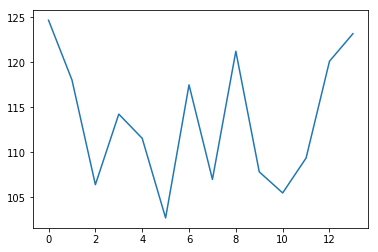

In [237]:
plt.plot(loss)

## Class for converting Sentences with Word2Vec class into vectors for representing sentences in vector form

# Comparison models of embeddings

## There are 3 base models, which included into our experiments for classifient feedbacks grades

In [54]:
import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier